In [34]:
import numpy as np

import fastmri
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastmri.data import transforms
import sigpy.plot as pl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

from fastmri.models.unet import Unet
from fastmri.models.varnet import *
from dloader import genDataLoader

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import peak_signal_noise_ratio as psnr

In [9]:
# We can make one iteration block like this
class VarNetBlock(nn.Module):
    """
    This model applies a combination of soft data consistency with the input
    model as a regularizer. A series of these blocks can be stacked to form
    the full variational network.
    """

    def __init__(self, model: nn.Module):
        """
        Args:
            model: Module for "regularization" component of variational
                network.
        """
        super().__init__()

        self.model = model
        self.eta = nn.Parameter(torch.ones(1)) # eta variable (traineable)

    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps)) # F*S operator

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        x = fastmri.ifft2c(x)
        return fastmri.complex_mul(x, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        ) # S^H * F^H operator

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
    ) -> torch.Tensor:
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta
        model_term = self.sens_expand(
            self.model(self.sens_reduce(current_kspace, sens_maps)), sens_maps
        )

        return current_kspace - soft_dc - model_term

In [10]:
# now we can stack VarNetBlocks to make a unrolled VarNet (with 10 blocks)


class VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBock.
    """

    def __init__(
        self,
        num_cascades: int = 10,
        chans: int = 18,
        pools: int = 4,
    ):
        super().__init__()

        self.cascades = nn.ModuleList(
            [VarNetBlock(NormUnet(chans, pools)) for _ in range(num_cascades)]
        )

    def forward(self, masked_kspace: torch.Tensor, mask: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        kspace_pred = masked_kspace.clone()

        for cascade in self.cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, sens_maps)
        
        im_coil = fastmri.ifft2c(kspace_pred)
        im_comb = fastmri.complex_mul(im_coil, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        )
        
        return im_comb

In [11]:
varnet = VarNet() # first construct VarNet
basefolder = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test'
dloader = genDataLoader(basefolder)

In [19]:
# test if backpropagation works
# if no error then backpropagation is working
test_dloader = iter(dloader)

In [12]:
kspace, mask, sens, im_true = next(test_dloader)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet.parameters(),lr=0.0002)
optimizer.zero_grad() 
im_est = varnet(kspace,mask,sens)
loss = criterion(im_est, im_true)
print('Initial Loss:', loss.item())
loss.backward() # this performs the backprop
optimizer.step() # this performs the gradient update

Initial Loss: 0.24175824224948883


In [22]:
# now perform this on cuda
kspace, mask, sens, im_true = next(test_dloader)
varnet_gpu = varnet.to('cuda:2')
kspace_gpu, mask_gpu, sens_gpu, im_true_gpu = kspace.to('cuda:2'), mask.to('cuda:2'), sens.to('cuda:2'), im_true.to('cuda:2')
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet_gpu.parameters(),lr=0.0002)
optimizer.zero_grad() 
im_est_gpu = varnet(kspace_gpu,mask_gpu,sens_gpu)
loss = criterion(im_est_gpu, im_true_gpu)
print('Initial Loss:', loss.item())
loss.backward() # this performs the backprop
optimizer.step() # this performs the gradient update

Initial Loss: 0.1131015196442604


In [ ]:
# let's train for a short epoch on the test set
# See if loss is decreasing (network is learning something)
Nepoch = 5
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet_gpu.parameters(),lr=0.0002)

for epoch in range(Nepoch):
    loss_epoch = 0
    for kspace, mask, sens, im_true in dloader:
        kspace_gpu, mask_gpu, sens_gpu, im_true_gpu = kspace.to('cuda:2'), mask.to('cuda:1'), sens.to('cuda:2'), im_true.to('cuda:2')
        optimizer.zero_grad() 
        im_est_gpu = varnet(kspace_gpu,mask_gpu,sens_gpu)
        loss = criterion(im_est_gpu, im_true_gpu)
        loss.backward() # this performs the backprop
        optimizer.step() # this performs the gradient update
        loss_epoch += loss.item()
    print('epoch:{}/{} Mean Loss: {}'.format(epoch, Nepoch, loss_epoch / len(dloader))) # report loss for end of the epoch


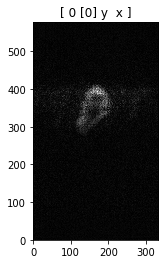

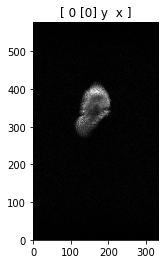

In [21]:
%matplotlib inline
# Let's look at the final produced image
im_est = transforms.tensor_to_complex_np(im_est_gpu.cpu().detach())
im_true = transforms.tensor_to_complex_np(im_true_gpu.cpu().detach())

pl.ImagePlot(im_est) # this is est image
pl.ImagePlot(im_true) # this is true image

# it produces some kind of similar images


In [43]:
def count_parameters(model):
    return sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )

def loss(im_us: torch.Tensor, im_fs: torch.Tensor):
    '''
    @parameter im_us: undersampled image (2D)
    @parameter im_fs: fully sampled image (2D)
    should be on GPU device for fast computation
    '''
    
    # use l1 loss between two images
    criterion = nn.L1Loss()
    
    # can add more fancy loss functions here later
    
    return criterion(im_us, im_fs)


def metric(im_us: torch.Tensor, im_fs: torch.Tensor):
    '''
    @parameter im_us: undersampled image (2D)
    @parameter im_fs: fully sampled image (2D)
    should be on GPU device
    '''
    
    # change to ndarray
    im_us = transforms.tensor_to_complex_np(im_us.cpu().detach())
    im_fs = transforms.tensor_to_complex_np(im_fs.cpu().detach())
    
    # convert complex nums to magnitude
    im_us = np.absolute(im_us)
    im_fs = np.absolute(im_fs)
    
    im_us = im_us.reshape(
        (im_us.shape[2], im_us.shape[3])
    )
    
    im_fs = im_fs.reshape(
        (im_fs.shape[2], im_fs.shape[3])
    )
    
    
    print(im_us.shape, im_fs.shape)

    
    # ssim
    ssim(im_fs, im_us)
    
    return psnr(im_fs, im_us)
    # 
    
    # psnr
    

In [44]:
metric(im_est_gpu, im_true_gpu)

(577, 332) (577, 332)


ValueError: im_true has intensity values outside the range expected for its data type.  Please manually specify the data_range

In [49]:
torch.min(im_true_gpu)

tensor(-1.1609, device='cuda:2')

In [50]:
torch.max(im_true_gpu)

tensor(2.6529, device='cuda:2')

In [70]:
# single task wrapper
skimage.__version__

'0.18.1'

In [ ]:
skimage.metrics.normalized_root_mse(…[, …])



skimage.metrics.peak_signal_noise_ratio(…)


skimage.metrics.structural_similarity(im1, …)